# Human Activity Recognition Using Smartphones

### Udacity Data Sciene Nanodegree, Capstone Project

### Overview

The prevalence of accelerometers and gyroscopes in modern smartphones has opened up significant opportunities to look at and understand this data on a large scale, and has many potential applications in health monitoring, activity tracking, and personal assistance. 

The purpose of this project is to build a model to classify human activity using data from smartphone sensors. 

The data we will be using is the Human Activity Recognition dataset from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

A write up of this project can be found here: https://medium.com/@bcheung.888/human-activity-recognition-using-smartphones-20f5758976ff


### 1) Initial exploration and analysis

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, cross_val_score

import warnings
warnings.filterwarnings('ignore')

Import data

In [2]:
# sensor data
X_train = pd.read_csv('./data/train/X_train.txt', sep='\s+', header=None)
X_test = pd.read_csv('./data/test/X_test.txt', sep='\s+', header=None)

# sensor labels
sensor_labels = pd.read_csv('./data/features.txt', sep=' ', header=None, names=('ID','Sensor'))

# activity class
y_train = pd.read_csv('./data/train/y_train.txt', sep='\s+', header=None, names='Y')
y_test = pd.read_csv('./data/test/y_test.txt', sep='\s+', header=None, names='Y')

# activity labels
activity_labels = pd.read_csv('./data/activity_labels.txt', sep=' ', header=None, names=('ID','Activity'))

Have a look at the activity labels and the target data

In [3]:
activity_labels.head(6)

,ID,Activity
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [4]:
y_train['Y'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: Y, dtype: int64

In [5]:
y_test['Y'].value_counts()

6    537
5    532
1    496
4    491
2    471
3    420
Name: Y, dtype: int64

In [6]:
print(y_train.shape)
print(y_test.shape)

(7352, 1)
(2947, 1)


#### We can see 6 activity types in the test/train target data as described with similar proportions of each. As described in the readme, 70% of the volunteers were used to generate the train data, and 30% to generate the test data.

Now, apply the sensor labels to the X data, and have a look through

In [7]:
sensor_labels.head()

,ID,Sensor
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [8]:
X_train.columns = sensor_labels['Sensor']
X_test.columns = sensor_labels['Sensor']

In [9]:
X_train.head()

Sensor,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [10]:
print(X_train.shape)
print(X_test.shape)

(7352, 561)
(2947, 561)


In [11]:
X_train.describe()

Sensor,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


###### We can see that sensor readings are captured on 3 axes and have been preprocessed and bounded between [-1,1]

In [12]:
# look at the data through a correlation matrix
correlations = X_train.corr()

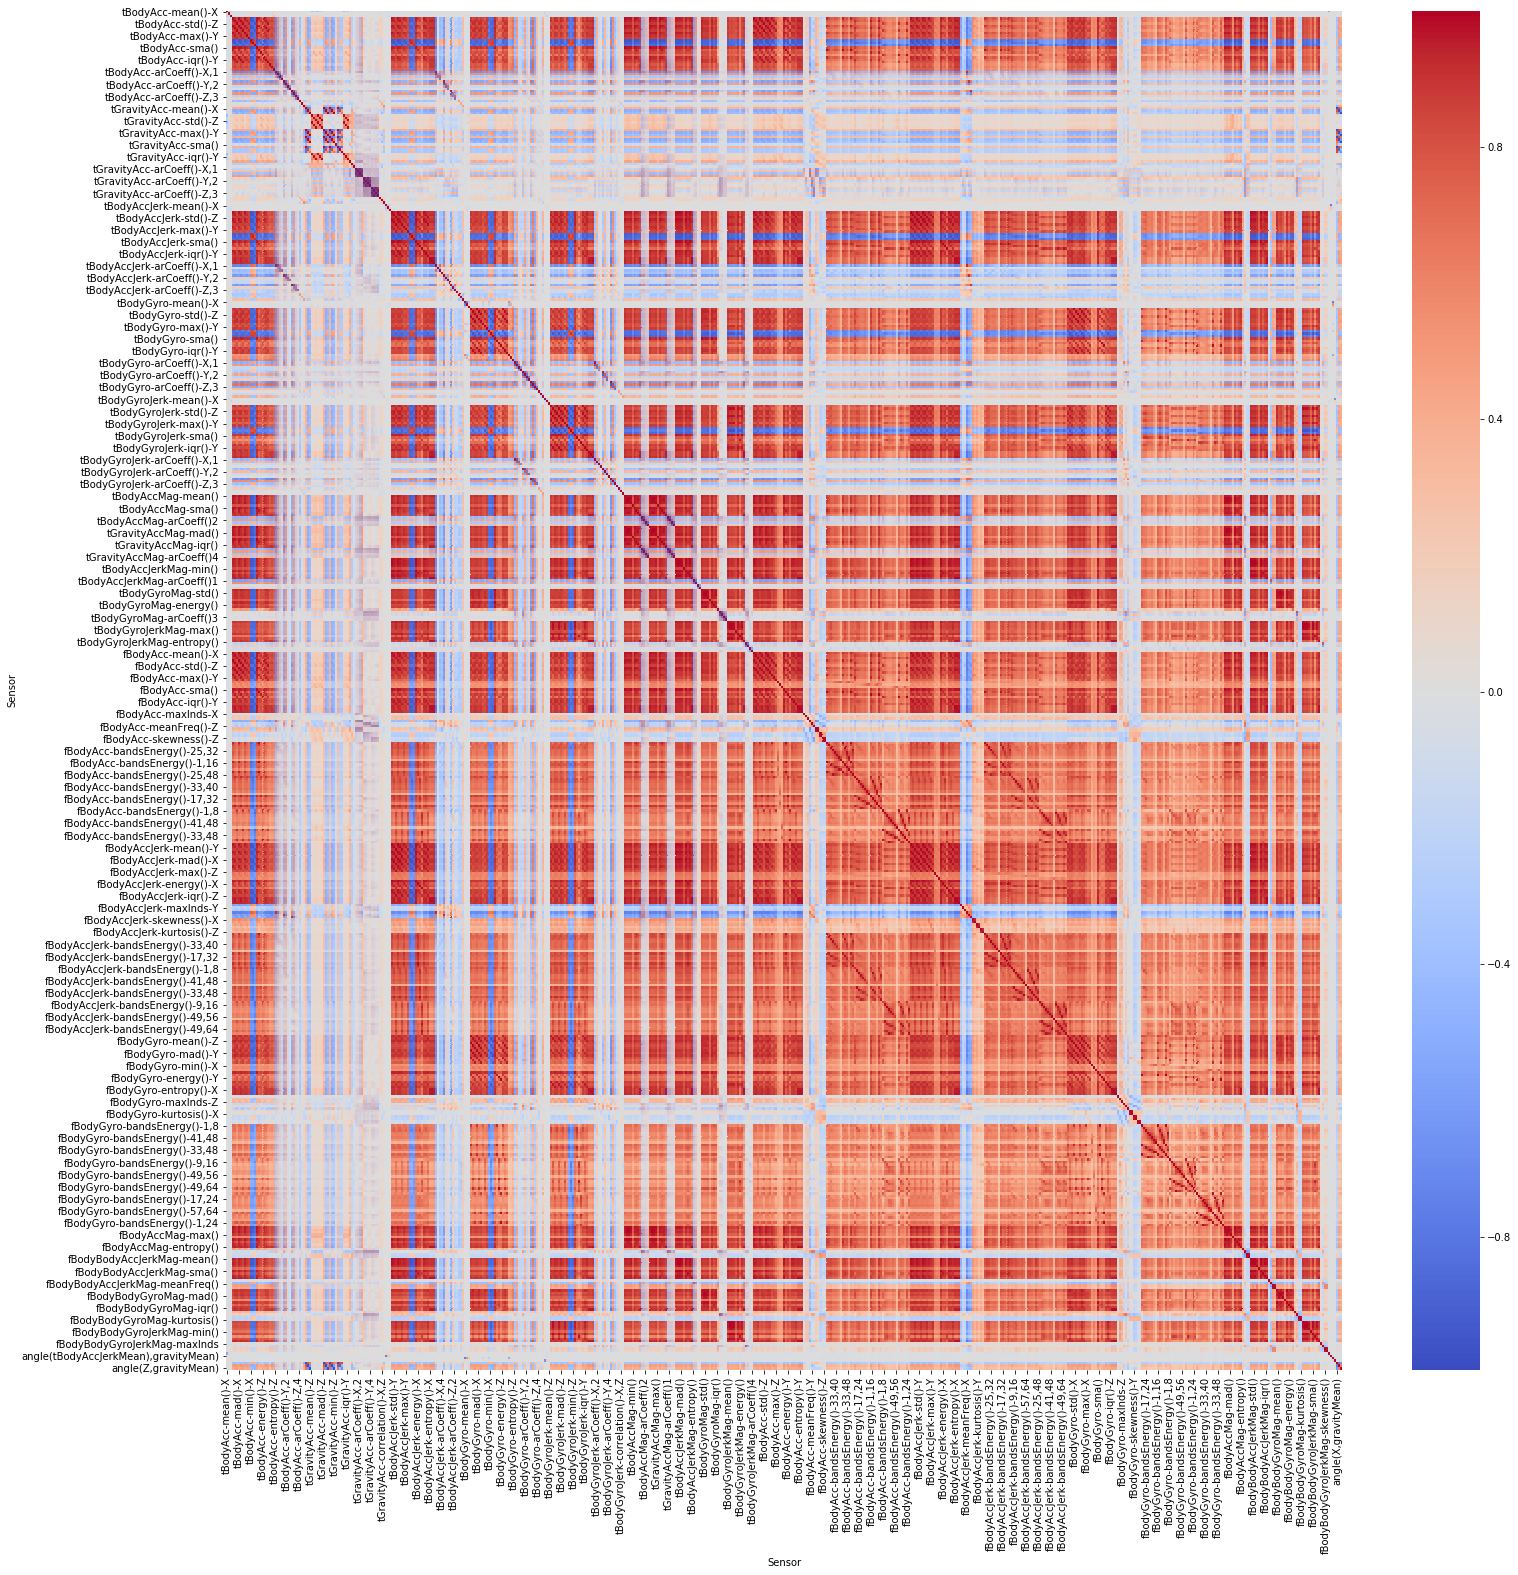

In [13]:
# plot on a heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlations, cmap='coolwarm')
plt.show()

#### Some correlation evident in the data. Should be expected as its signal data (and related derived variables) measuring aspects/forces on the body doing certain activities.

A visual exploration of 561 variables would be unreasonable. Let's try to visualise the data in 3 dimensions with principal components instead.

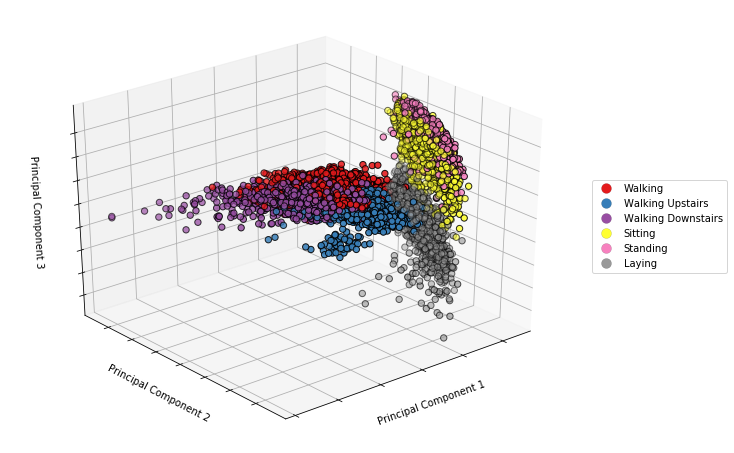

In [14]:
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_train)
y = y_train['Y']

labels = [('Walking', 1), ('Walking Upstairs', 2), ('Walking Downstairs', 3), 
          ('Sitting', 4), ('Standing', 5), ('Laying', 6)]

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=130)
sc= ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=y, cmap='Set1', edgecolor='k', s=40)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

colors = [sc.cmap(sc.norm(i)) for i in [1,2,3,4,5,6]]
custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                mec='k', mfc=c, mew=.1, ms=20) for c in colors]
ax.legend(custom_lines, [l[0] for l in labels], 
          loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

#### We can see 6 fairly distinct colour groupings within 2 main clusters - the 3 variations of walking are close together as one would expect. The mostly static activities of Sitting/Standing/Laying are similarly close together.

It should be possible to reduce the dimensionality of the data, so let's see what PCA can tell us.

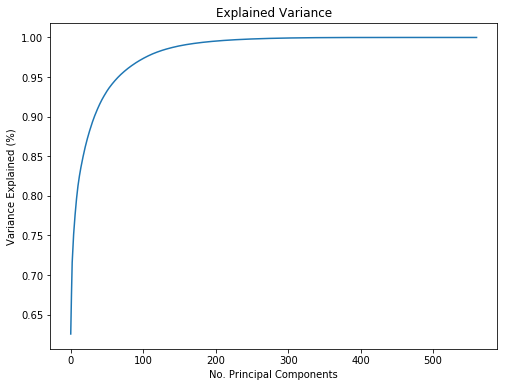

In [15]:
pca = PCA()
X_pca = pca.fit_transform(X_train)

# function borrowed from course content
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components and displays the cumulative variance explained
    
    INPUT: pca - the result of instantiating PCA in sklearn
            
    OUTPUT: None
    '''
    
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)

    ax.plot(ind, cumvals)

    ax.set_xlabel("No. Principal Components")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance')
    
scree_plot(pca)

#### ~100 components captures more than 95% of the variance in the X train data. ~200 components captures nearly 100%.

### 2) Model build

The objective is to build a classifier that can classify the different activity types, even when extended to new data (i.e.: new participants). Accuracy will therefore be used as the evaluation metric.

We'll try to do this with the following 3 models: 

#### K-nearest neighbours
A less complex model, but could serve as a good baseline. Should work reasonably well given that the same activity types should generate similar signal data.
    
#### Random forest
A random forest should also perform well as our data is fairly high dimension, and the randomness from bootstrap sampling and only using a subset of features may help correctly classify more activities.

#### Support vector machine
As indicated by PCA (and intuition..!), some activities are quite similar to each other. Maximising margins when separating the different activities may lead to a strong performance.

In [16]:
# fit a KNN to the data 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train.values.ravel())

train_pred = knn.predict(X_train)
y_pred = knn.predict(X_test)

print('Accuracy score TRAIN: ', format(accuracy_score(y_train, train_pred)))
print('Accuracy score TEST: ', format(accuracy_score(y_test, y_pred)))

Accuracy score TRAIN:  0.9843579978237215
Accuracy score TEST:  0.9015948422124194


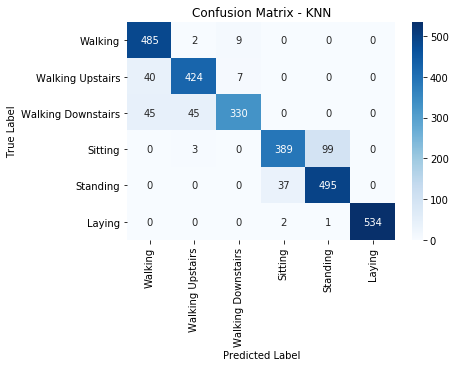

In [17]:
# confusion matrix for KNN
cm = confusion_matrix(y_test, y_pred)

ax = plt.axes()
sns.heatmap(cm, 
            fmt='.0f', 
            annot=True, 
            cmap='Blues',
            xticklabels=['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying'],
            yticklabels=['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying'],
            ax = ax)

ax.set_title('Confusion Matrix - KNN')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

Baseline KNN classifier has performed quite well with ~90% accuracy on the test data. A fair amount of accuracy loss can be seen moving from train to test data, though reasonable given that it was generated from different participants. Confusion matrix confirms moderate performance across all 6 activity types.

In [18]:
# fit random forest to the data
# set n_estimators to 100. 10 is a bit low, and its been indicated it will change to this in a future version
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.values.ravel())

train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

print('Accuracy score TRAIN: ', format(accuracy_score(y_train, train_pred)))
print('Accuracy score TEST: ', format(accuracy_score(y_test, y_pred)))

Accuracy score TRAIN:  1.0
Accuracy score TEST:  0.9256871394638616


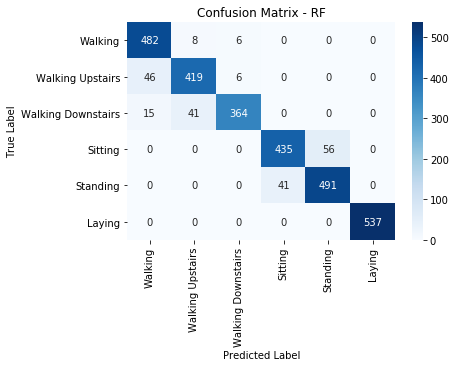

In [19]:
# confusion matrix for RF
cm = confusion_matrix(y_test, y_pred)

ax = plt.axes()
sns.heatmap(cm, 
            fmt='.0f', 
            annot=True, 
            cmap='Blues',
            xticklabels=['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying'],
            yticklabels=['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying'],
            ax = ax)

ax.set_title('Confusion Matrix - RF')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

A random forest classifier gives a small improvement in accuracy on the test data to ~92.5%. Improvements in classification of both walking and static activities can be seen in the confusion matrix. The 100% accuracy on train data is noted.

In [20]:
# Fit a linear SVM to the data
svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train.values.ravel())

train_pred = svc.predict(X_train)
y_pred = svc.predict(X_test)

print('Accuracy score TRAIN: ', format(accuracy_score(y_train, train_pred)))
print('Accuracy score TEST: ', format(accuracy_score(y_test, y_pred)))

Accuracy score TRAIN:  0.9946953210010882
Accuracy score TEST:  0.9670851713607058


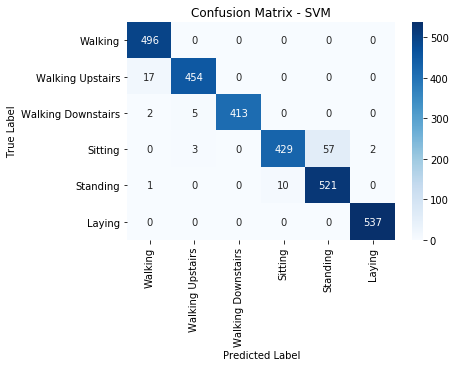

In [21]:
# confusion matrix for Linear SVM
cm = confusion_matrix(y_test, y_pred)

ax = plt.axes()
sns.heatmap(cm, 
            fmt='.0f', 
            annot=True, 
            cmap='Blues',
            xticklabels=['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying'],
            yticklabels=['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying'],
            ax = ax)

ax.set_title('Confusion Matrix - SVM')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

SVM with linear kernel gives 96.7% accuracy on the test data - quite a strong performance.

Confusion matrix indicates there is still a bit of a struggle in classifying some sitting and standing activities. Reasonable for this to occur and natural variation between how people perform activities could plausibly explain the difference between train and test accuracy. Result may be hard to beat.

### 3) Attempt to improve model

SVM seems the most promising. Let's try different kernels first.

In [22]:
clf = SVC(random_state=42)

# try different kernels via gridsearch
parameters = {'kernel': ['poly', 'rbf', 'sigmoid']}

grid_obj =  GridSearchCV(clf, parameters, cv=3)
grid_fit = grid_obj.fit(X_train, y_train.values.ravel())

best_clf = grid_fit.best_estimator_
train_pred = best_clf.predict(X_train)
best_pred = best_clf.predict(X_test)

print(best_clf)
print('Accuracy score TRAIN: ', format(accuracy_score(y_train, train_pred)))
print('Accuracy score TEST: ', format(accuracy_score(y_test, best_pred)))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)
Accuracy score TRAIN:  0.955658324265506
Accuracy score TEST:  0.9402782490668476


No improvement with different kernels. Let's go back to the linear kernel SVM and try some adjustments.

In [23]:
clf = LinearSVC(random_state=42)

# try linear SVM with different C parameter an loss function
parameters = {'C': [0.1, 1, 10],
              'loss': ['hinge','squared_hinge']
             }

grid_obj =  GridSearchCV(clf, parameters, cv=3)
grid_fit = grid_obj.fit(X_train, y_train.values.ravel())

best_clf = grid_fit.best_estimator_
train_pred = best_clf.predict(X_train)
best_pred = best_clf.predict(X_test)

print(best_clf)
print('Accuracy score TRAIN: ', format(accuracy_score(y_train, train_pred)))
print('Accuracy score TEST: ', format(accuracy_score(y_test, best_pred)))

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
Accuracy score TRAIN:  0.9942872687704026
Accuracy score TEST:  0.9677638276213099


Insignificant improvement to the accuracy score: ~96.8%

We saw earlier that ~200 principal components could explain nearly all of the variance in the data. Let's use that in the SVM.

In [24]:
# fit linear SVC with 200 principal components 
pca_200 = PCA(n_components=200, random_state=42)
X_pca_200 = pca_200.fit_transform(X_train)

X_test_pca = pca_200.transform(X_test)

svc = LinearSVC(random_state=42)
svc.fit(X_pca_200, y_train.values.ravel())

train_pred = svc.predict(X_pca_200)
y_pred = svc.predict(X_test_pca)

print('Accuracy score TRAIN: ', format(accuracy_score(y_train, train_pred)))
print('Accuracy score TEST: ', format(accuracy_score(y_test, y_pred)))

Accuracy score TRAIN:  0.9945593035908596
Accuracy score TEST:  0.9650492025788938


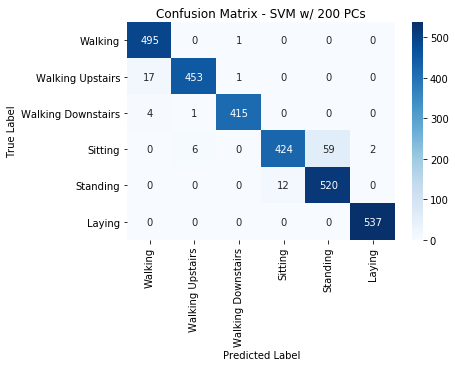

In [25]:
# confusion matrix for Linear SVM w/ 200 PCs
cm = confusion_matrix(y_test, y_pred)

ax = plt.axes()
sns.heatmap(cm, 
            fmt='.0f', 
            annot=True, 
            cmap='Blues',
            xticklabels=['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying'],
            yticklabels=['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying'],
            ax = ax)

ax.set_title('Confusion Matrix - SVM w/ 200 PCs')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

Similarly insignificant change to accuracy score (~96.5%)

### 4) Model Evaluation:

We'll retain the linear SVM with original 561 features. PCA did not improve performance and may also be computationally problematic at large scale. 

As a final evaluation of model performance, we'll perform leave one out cross validation - train the model on 29 participants and test on the 30th. This will highlight how the model performs on different participants and simulate how robust the model would be in practice. 

In [26]:
# combine train/test data
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

print(X.shape)
print(y.shape)

(10299, 561)
(10299, 1)


In [27]:
# file identifying which participant peformed each row
subject_train = pd.read_csv('./data/train/subject_train.txt', sep='\s+', header=None)
subject_test = pd.read_csv('./data/test/subject_test.txt', sep='\s+', header=None)

subjects = pd.concat([subject_train, subject_test])

logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, subjects)

30

In [28]:
clf = LinearSVC(random_state=42)
cv = logo.split(X, y, subjects.values.ravel())
scores = cross_val_score(clf, X, y, cv=cv)
scores

array([0.97982709, 0.98675497, 0.99706745, 0.97476341, 0.93046358,
       0.88923077, 0.9512987 , 0.97864769, 0.92361111, 0.92176871,
       1.        , 0.96875   , 0.99388379, 0.79876161, 1.        ,
       0.86885246, 0.96467391, 0.99450549, 0.98611111, 0.96610169,
       0.96813725, 0.99688474, 0.98655914, 0.99212598, 0.96577017,
       0.99489796, 0.98138298, 0.96858639, 0.98255814, 0.99477807])

In [29]:
subject_misclass = pd.concat([pd.Series(1-scores), pd.Series(np.unique(subjects))], axis=1)
subject_misclass.columns=['Misclassificaton Rate','Subject']
subject_misclass.sort_values('Misclassificaton Rate', inplace=True, ascending=False)

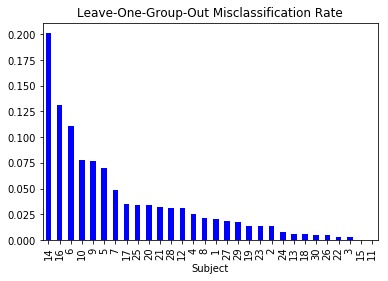

In [30]:
subject_misclass.plot.bar(x='Subject', y='Misclassificaton Rate', color='b', 
                  legend=False, title='Leave-One-Group-Out Misclassification Rate')
plt.show()

Misclassification error varies from 0 to ~20%. Participants 14, 16, 6 have an error rate > 10%, but the model performs quite well on the other 27. 

Intuitively, model performance depends on how similarly a new (test) participant performs the activities relative to the participants the model was trained on. Training the model on more participants, along with a closer analysis of sitting vs standing activities could go some way towards improving model performance.

### 5) Model Summary:

|     Model              | Accuracy          | 
| :------------:         | :---------------: |
| K-Nearest Neighbours   |       0.902       |
| Random Forest          |       0.926       |
| SVM-Linear             |       0.967       |
| SVM-rbf                |       0.940       |
| SVM-Linear (200 PCs)   |       0.965       |


Our K-Nearest Neighbours classifier had the lowest accuracy at ~90%. This is reasonable as its a less complex technique, and as we can infer from the 3D principal component plot, it may have struggled more when similar signals are generated from different activities.

Our Support Vector Machine with a linear kernel performed the best with 96-97% accuracy. A gridsearch did not lead to a significant improvement to the model. Reducing dimensionality to 200 principal components also had an insignificant effect on accuracy. 

SVM Linear with the original data could be a good model to implement. Though it still struggles to classify sitting/standing in some cases, they are both "static" type activities and in the context of activity or exercise tracking, could reasonably have lesser significance than the walking activities.